Kmeans Clustering: Melakukan Clustering pekerja berdasarkan workload dan skor audit

Logistic Regression: Prediksi apakah AI digunakan berdasarkan beban kerja dan skor efektivitas

# Logistic regression
1. Variabel Target (Kolom Output):
AI_Used_for_Auditing (di-encode menjadi AI_Used_for_Auditing_Encoded [0 untuk 'No', 1 untuk 'Yes'])

2. Fitur Input (Kolom Input yang Digunakan Model):
Numerik:
- Employee_Workload
- Audit_Effectiveness_Score
- Total_Revenue_Impact
- High_Risk_Cases
- Compliance_Violations
- Workload_x_Effectiveness (Fitur turunan yang dibuat secara manual dari Employee_Workload * Audit_Effectiveness_Score)

3. Kategorikal (yang kemudian di-one-hot encode oleh pipeline(keseluruhan alur)): 
- Firm_Name 
- Industry_Affected

# K-Means Clustering
Fitur Input (Kolom Input yang Digunakan Model - setelah di-scaling):
- Employee_Workload
- Audit_Effectiveness_Score

# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
import joblib

# Data Understanding

In [2]:
# Muat dataset
df = pd.read_csv('big4_financial_risk_compliance.csv')

In [3]:
# Tampilkan beberapa baris pertama
print("Data Awal (Head):")
print(df.head())

Data Awal (Head):
   Year Firm_Name  Total_Audit_Engagements  High_Risk_Cases  \
0  2020       PwC                     2829               51   
1  2022  Deloitte                     3589              185   
2  2020       PwC                     2438              212   
3  2021       PwC                     2646              397   
4  2020       PwC                     2680              216   

   Compliance_Violations  Fraud_Cases_Detected Industry_Affected  \
0                    123                    39        Healthcare   
1                     30                    60        Healthcare   
2                    124                    97        Healthcare   
3                     55                    97        Healthcare   
4                     99                    46        Healthcare   

   Total_Revenue_Impact AI_Used_for_Auditing  Employee_Workload  \
0                114.24                   No                 57   
1                156.98                  Yes                

In [4]:
# Informasi umum dataset
print("\nInformasi Dataset:")
df.info()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       100 non-null    int64  
 1   Firm_Name                  100 non-null    object 
 2   Total_Audit_Engagements    100 non-null    int64  
 3   High_Risk_Cases            100 non-null    int64  
 4   Compliance_Violations      100 non-null    int64  
 5   Fraud_Cases_Detected       100 non-null    int64  
 6   Industry_Affected          100 non-null    object 
 7   Total_Revenue_Impact       100 non-null    float64
 8   AI_Used_for_Auditing       100 non-null    object 
 9   Employee_Workload          100 non-null    int64  
 10  Audit_Effectiveness_Score  100 non-null    float64
 11  Client_Satisfaction_Score  100 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 9.5+ KB


In [5]:
# Statistik deskriptif untuk fitur numerik
print("\nStatistik Deskriptif (Numerik):")
print(df.describe())


Statistik Deskriptif (Numerik):
              Year  Total_Audit_Engagements  High_Risk_Cases  \
count   100.000000               100.000000       100.000000   
mean   2022.320000              2784.520000       277.730000   
std       1.780251              1281.863073       135.735174   
min    2020.000000               603.000000        51.000000   
25%    2021.000000              1768.250000       162.500000   
50%    2022.000000              2650.000000       293.000000   
75%    2024.000000              4008.750000       395.500000   
max    2025.000000              4946.000000       500.000000   

       Compliance_Violations  Fraud_Cases_Detected  Total_Revenue_Impact  \
count             100.000000            100.000000            100.000000   
mean              105.480000             52.700000            272.539000   
std                55.370101             28.311221            139.151401   
min                10.000000              5.000000             33.460000   
25%       

In [6]:
# Statistik deskriptif untuk fitur kategorikal
print("\nStatistik Deskriptif (Kategorikal):")
print(df.describe(include='object'))


Statistik Deskriptif (Kategorikal):
       Firm_Name Industry_Affected AI_Used_for_Auditing
count        100               100                  100
unique         4                 4                    2
top     Deloitte              Tech                   No
freq          30                29                   55



Nilai Hilang per Kolom:
Year                         0
Firm_Name                    0
Total_Audit_Engagements      0
High_Risk_Cases              0
Compliance_Violations        0
Fraud_Cases_Detected         0
Industry_Affected            0
Total_Revenue_Impact         0
AI_Used_for_Auditing         0
Employee_Workload            0
Audit_Effectiveness_Score    0
Client_Satisfaction_Score    0
dtype: int64


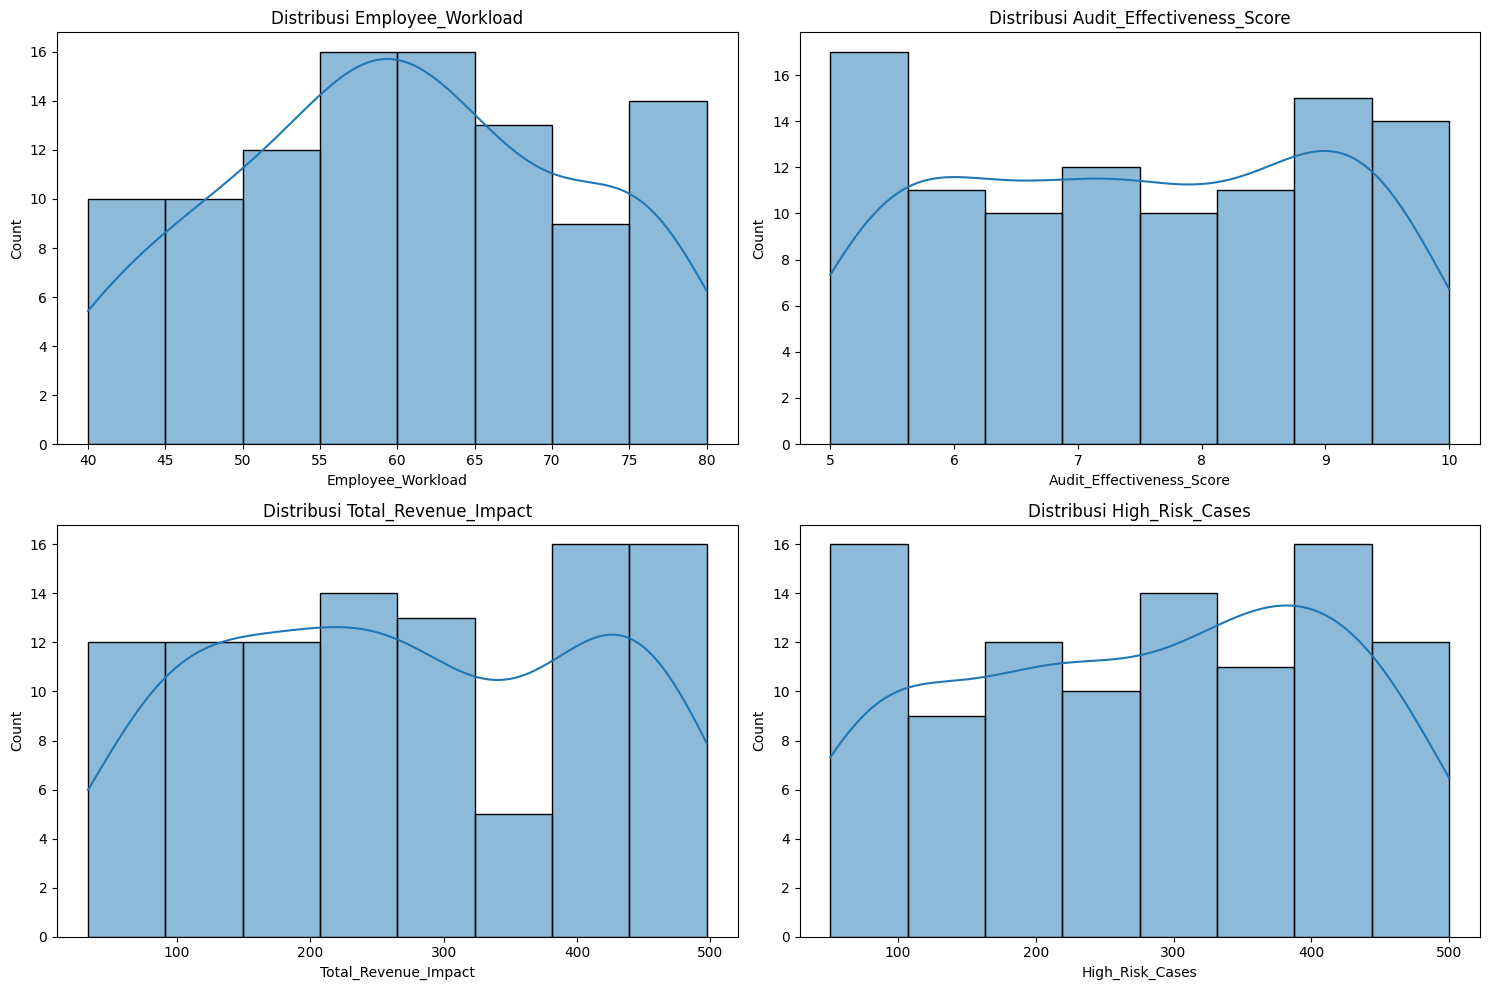

In [9]:
# Visualisasi distribusi untuk beberapa fitur numerik kunci
numerical_cols_plot = ['Employee_Workload', 'Audit_Effectiveness_Score', 'Total_Revenue_Impact', 'High_Risk_Cases']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_plot):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

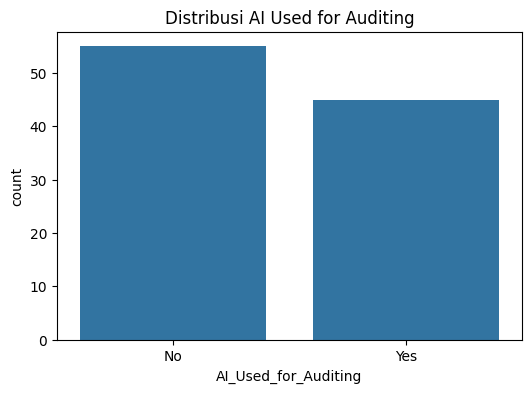

AI_Used_for_Auditing
No     0.55
Yes    0.45
Name: proportion, dtype: float64


In [10]:
# Visualisasi distribusi untuk target variable (AI_Used_for_Auditing)
plt.figure(figsize=(6, 4))
sns.countplot(x='AI_Used_for_Auditing', data=df)
plt.title('Distribusi AI Used for Auditing')
plt.show()
print(df['AI_Used_for_Auditing'].value_counts(normalize=True))

# Data Preparation

In [ ]:
# Cek nilai yang hilang (missing values)
print("\nNilai Hilang per Kolom:")
print(df.isnull().sum())

In [ ]:
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah baris data duplikat yang ditemukan: {jumlah_duplikat}")

# Data Preparation untuk Regresi Logistik

In [11]:
# Encode variabel target 'AI_Used_for_Auditing'
le = LabelEncoder()
df['AI_Used_for_Auditing_Encoded'] = le.fit_transform(df['AI_Used_for_Auditing']) # Output: 0 untuk 'No', 1 untuk 'Yes'

In [12]:
# Membuat fitur interaksi 'Workload_x_Effectiveness'
df['Workload_x_Effectiveness'] = df['Employee_Workload'] * df['Audit_Effectiveness_Score']

In [13]:
# Definisikan fitur numerik dan kategorikal untuk Regresi Logistik
# Fitur interaksi sudah termasuk dalam df dan akan dipilih di sini.
numerical_features_logreg = [
    'Employee_Workload', 'Audit_Effectiveness_Score', 
    'Total_Revenue_Impact', 'High_Risk_Cases', 'Compliance_Violations',
    'Workload_x_Effectiveness' # Fitur interaksi yang dibuat manual
]
categorical_features_logreg = ['Firm_Name', 'Industry_Affected']

In [14]:
# Definisikan X dan y untuk Regresi Logistik
X_logreg = df[numerical_features_logreg + categorical_features_logreg]
y_logreg = df['AI_Used_for_Auditing_Encoded']

In [15]:
# Split data menjadi training dan testing set
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(
    X_logreg, y_logreg, test_size=0.3, random_state=42, stratify=y_logreg
)

In [16]:
# Membuat preprocessor untuk Regresi Logistik
numerical_pipeline_logreg = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline_logreg = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_logreg = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_logreg, numerical_features_logreg),
        ('cat', categorical_pipeline_logreg, categorical_features_logreg)
    ])

# Data Preparation untuk K-Means Clustering

In [17]:
# Fitur untuk K-Means
features_kmeans = ['Employee_Workload', 'Audit_Effectiveness_Score']
X_kmeans = df[features_kmeans].copy() # Gunakan df asli sebelum ada fitur interaksi

In [18]:
# Preprocessing untuk K-Means: Scaling
scaler_kmeans = StandardScaler()
X_kmeans_scaled = scaler_kmeans.fit_transform(X_kmeans)

# Modeling

# Modeling Regresi Logistik

In [19]:
# Membuat pipeline lengkap untuk Regresi Logistik (preprocessor + classifier)
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_logreg),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
])

In [20]:
# %%
# Melatih model Regresi Logistik
logreg_pipeline.fit(X_train_logreg, y_train_logreg)
print("Model Regresi Logistik berhasil dilatih.")

Model Regresi Logistik berhasil dilatih.


# Modeling K-Means Clustering

In [21]:
# Menentukan jumlah cluster optimal (k) menggunakan Elbow Method
inertia = []
k_range = range(1, 11)
for k_val in k_range:
    kmeans_temp = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
    kmeans_temp.fit(X_kmeans_scaled)
    inertia.append(kmeans_temp.inertia_)


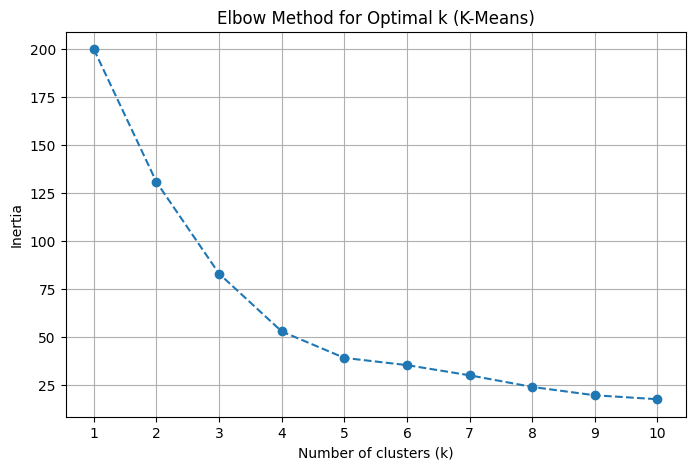

In [22]:
# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [23]:
optimal_k = 3
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_model.fit(X_kmeans_scaled)
cluster_labels = kmeans_model.predict(X_kmeans_scaled)
df['KMeans_Cluster'] = cluster_labels # Tambahkan label cluster ke df utama untuk analisis
print(f"Model K-Means berhasil dilatih dengan k={optimal_k}.")

Model K-Means berhasil dilatih dengan k=3.


# Evaluation

# Evaluasi Regresi Logistik

In [24]:
# Prediksi pada data uji
y_pred_logreg = logreg_pipeline.predict(X_test_logreg)

In [25]:
# Metrik evaluasi
accuracy_logreg = accuracy_score(y_test_logreg, y_pred_logreg)
print(f"Akurasi Regresi Logistik: {accuracy_logreg:.4f}") 

Akurasi Regresi Logistik: 0.6000


In [26]:
print("\nLaporan Klasifikasi Regresi Logistik:")
print(classification_report(y_test_logreg, y_pred_logreg, target_names=le.classes_))


Laporan Klasifikasi Regresi Logistik:
              precision    recall  f1-score   support

          No       0.62      0.76      0.68        17
         Yes       0.56      0.38      0.45        13

    accuracy                           0.60        30
   macro avg       0.59      0.57      0.57        30
weighted avg       0.59      0.60      0.58        30



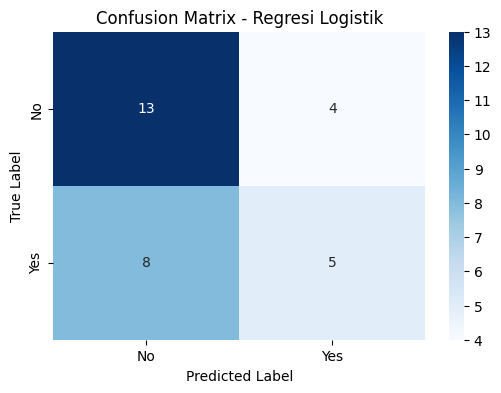

In [27]:
# Confusion Matrix
cm_logreg = confusion_matrix(y_test_logreg, y_pred_logreg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Regresi Logistik')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Evaluasi K-Means Clustering

In [28]:
# Silhouette Score
silhouette_avg_kmeans = silhouette_score(X_kmeans_scaled, cluster_labels)
print(f"Silhouette Score untuk K-Means (k={optimal_k}): {silhouette_avg_kmeans:.4f}")

Silhouette Score untuk K-Means (k=3): 0.3594


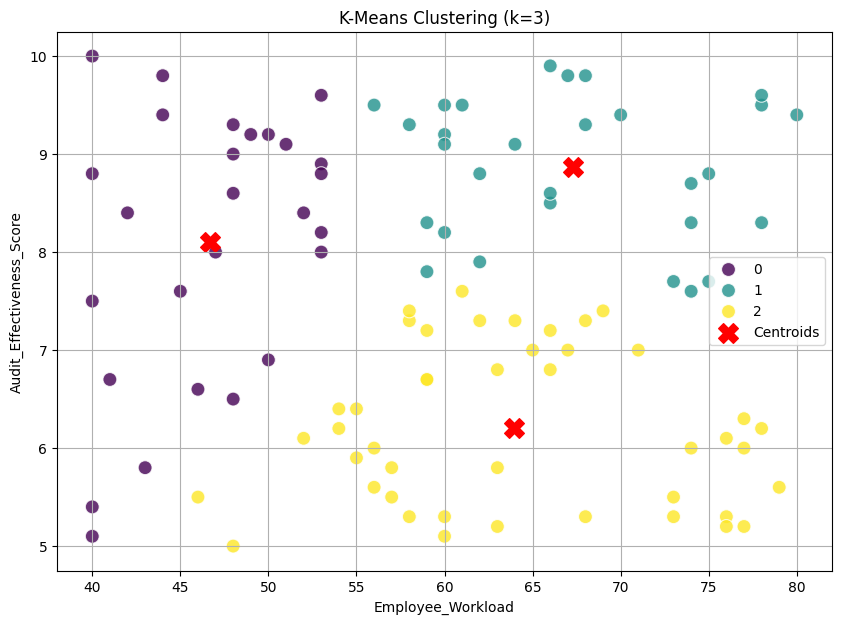

In [29]:
# Visualisasi Cluster K-Means
plt.figure(figsize=(10, 7))
# Menggunakan X_kmeans (data asli sebelum scaling) untuk plotting agar sumbu lebih mudah diinterpretasi
# Warna berdasarkan cluster_labels yang didapat dari X_kmeans_scaled
sns.scatterplot(x=X_kmeans.iloc[:, 0], y=X_kmeans.iloc[:, 1], hue=cluster_labels, palette='viridis', s=100, alpha=0.8)
# Plot centroids (perlu di-inverse transform dari skala asli)
centroids = scaler_kmeans.inverse_transform(kmeans_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red', label='Centroids')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel(features_kmeans[0])
plt.ylabel(features_kmeans[1])
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Profiling Cluster
print("\nProfil Rata-rata per Cluster (K-Means):")
# Menambahkan fitur lain untuk profiling jika diinginkan
profiling_features_kmeans = features_kmeans + ['Total_Revenue_Impact', 'High_Risk_Cases', 'Compliance_Violations', 'AI_Used_for_Auditing_Encoded']
# Memastikan semua kolom ada di df
existing_profiling_features = [col for col in profiling_features_kmeans if col in df.columns]

cluster_profile = df.groupby('KMeans_Cluster')[existing_profiling_features].mean()
print(cluster_profile)


Profil Rata-rata per Cluster (K-Means):
                Employee_Workload  Audit_Effectiveness_Score  \
KMeans_Cluster                                                 
0                       46.703704                   8.103704   
1                       67.275862                   8.865517   
2                       63.931818                   6.206818   

                Total_Revenue_Impact  High_Risk_Cases  Compliance_Violations  \
KMeans_Cluster                                                                 
0                         249.591111       281.814815             106.185185   
1                         263.920690       280.241379             107.310345   
2                         292.300909       273.568182             103.840909   

                AI_Used_for_Auditing_Encoded  
KMeans_Cluster                                
0                                   0.481481  
1                                   0.482759  
2                                   0.409091  


# Deployment (Penyimpanan Model)

In [31]:
# Simpan pipeline(alur lengkap) Regresi Logistik
joblib.dump(logreg_pipeline, 'logistic_regression_pipeline.joblib')

# Simpan daftar unik untuk dropdown di Streamlit
unique_firms = df['Firm_Name'].unique().tolist()
unique_industries = df['Industry_Affected'].unique().tolist()

joblib.dump(unique_firms, 'unique_firms.joblib')
joblib.dump(unique_industries, 'unique_industries.joblib')
print("List unik untuk Firm dan Industri disimpan sebagai 'unique_firms.joblib' dan 'unique_industries.joblib'.")

List unik untuk Firm dan Industri disimpan sebagai 'unique_firms.joblib' dan 'unique_industries.joblib'.


In [32]:
# Simpan model K-Means dan scaler-nya
joblib.dump(kmeans_model, 'kmeans_model.joblib')
joblib.dump(scaler_kmeans, 'kmeans_scaler.joblib') # Scaler yang di-fit pada X_kmeans

['kmeans_scaler.joblib']